In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from scipy import sparse

### Load training/test data

In [3]:
train = pd.read_json('./data/train.json')

In [4]:
test = pd.read_json('./data/test.json')

In [5]:
print train.shape, test.shape

(49352, 15) (74659, 14)


In [6]:
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [7]:
train.columns

Index([u'bathrooms', u'bedrooms', u'building_id', u'created', u'description',
       u'display_address', u'features', u'interest_level', u'latitude',
       u'listing_id', u'longitude', u'manager_id', u'photos', u'price',
       u'street_address'],
      dtype='object')

In [8]:
train.bathrooms.describe()

count    49352.00000
mean         1.21218
std          0.50142
min          0.00000
25%          1.00000
50%          1.00000
75%          1.00000
max         10.00000
Name: bathrooms, dtype: float64

In [9]:
train.bedrooms.value_counts()

1    15752
2    14623
0     9475
3     7276
4     1929
5      247
6       46
8        2
7        2
Name: bedrooms, dtype: int64

In [10]:
train.created.describe()

count                   49352
unique                  48675
top       2016-04-15 02:24:25
freq                        3
Name: created, dtype: object

In [11]:
train.created.max(), train.created.min()

(u'2016-06-29 21:41:47', u'2016-04-01 22:12:41')

In [12]:
train.created.dtype

dtype('O')

In [13]:
#### Remove outlier
train = train[train.price < 100000]

In [14]:
train.shape

(49345, 15)

### Date/time feature

In [15]:
# Change Dates columns to Python Date format
train['created'] = pd.to_datetime(train['created'], format='%Y-%m-%d %H:%M:%S')
test['created'] = pd.to_datetime(test['created'], format='%Y-%m-%d %H:%M:%S')
# Extract Date Features
import datetime as dt
train['weekday_created'] = train['created'].dt.weekday
train['month_created'] = train['created'].dt.month
train['day_created'] = train['created'].dt.day
train['hour_created'] = train['created'].dt.hour

test['weekday_created'] = test['created'].dt.weekday
test['month_created'] = test['created'].dt.month
test['day_created'] = test['created'].dt.day
test['hour_created'] = test['created'].dt.hour

### Features (of the listing) feature

In [16]:
train['feature_list'] = train['features'].map(lambda x: ','.join(x)).str.lower()
test['feature_list'] = test['features'].map(lambda x: ','.join(x)).str.lower()

In [17]:
train['number_of_features'] = train['features'].map(len)
test['number_of_features'] = test['features'].map(len)

In [18]:
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,manager_id,photos,price,street_address,weekday_created,month_created,day_created,hour_created,feature_list,number_of_features
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,4,6,24,7,,0
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,6,6,12,12,"doorman,elevator,fitness center,cats allowed,d...",5
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,6,4,17,3,"laundry in building,dishwasher,hardwood floors...",4
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,...,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,0,4,18,2,"hardwood floors,no fee",2
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,...,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,3,4,28,1,pre-war,1


In [19]:
len(train[train['feature_list']==''])

3218

In [20]:
train.loc[10000,'feature_list']

u'doorman,elevator,fitness center,cats allowed,dogs allowed'

In [21]:
all_features = train['feature_list'].str.cat(sep=',')

In [22]:
all_feature_list = all_features.split(',')

In [23]:
all_feature_list[:20]

[u'',
 u'doorman',
 u'elevator',
 u'fitness center',
 u'cats allowed',
 u'dogs allowed',
 u'laundry in building',
 u'dishwasher',
 u'hardwood floors',
 u'pets allowed case by case',
 u'hardwood floors',
 u'no fee',
 u'pre-war',
 u'',
 u'prewar',
 u'elevator',
 u'dogs allowed',
 u'cats allowed',
 u'lowrise',
 u'simplex']

In [24]:
len(all_feature_list)

271091

In [25]:
unique_feature_list = list(set(all_feature_list))

In [26]:
len(unique_feature_list)

1295

In [27]:
unique_feature_list[:10]

[u'',
 u'photos of actual apartment',
 u'** extravagant east village! * massive 4br mansion * 2 full baths * gourmet kitchen * roomy closets **',
 u'complimentary sunday brunch',
 u'sundeck with bbq grills',
 u'party room',
 u'private shuttle',
 u'spacious layout',
 u'cable ready',
 u'private garden']

In [28]:
df_unique = pd.DataFrame(unique_feature_list)

In [29]:
df_unique.to_csv('./data/unique_feature_list.csv', encoding='utf-8')

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
# vocabulary list from the unique feature list
# custom tokenizer to split by comma

count_vect = CountVectorizer(vocabulary=unique_feature_list, tokenizer=lambda x: x.split(','))
#count_vect = CountVectorizer(max_features=300, tokenizer=lambda x: x.split(','))

In [32]:
X_train_feature_counts = count_vect.fit_transform(train['feature_list'])

In [33]:
X_train_feature_counts

<49345x1295 sparse matrix of type '<type 'numpy.int64'>'
	with 270647 stored elements in Compressed Sparse Row format>

In [34]:
test_count_vect = CountVectorizer(vocabulary=unique_feature_list, tokenizer=lambda x: x.split(','))
#test_count_vect = CountVectorizer(vocabulary=count_vect.vocabulary_, tokenizer=lambda x: x.split(','))
X_test_feature_counts = count_vect.fit_transform(test['feature_list'])
X_test_feature_counts

<74659x1295 sparse matrix of type '<type 'numpy.int64'>'
	with 407785 stored elements in Compressed Sparse Row format>

In [35]:
#freqs = [(word, X_train_feature_counts.getcol(idx).sum()) for word, idx in count_vect.vocabulary_.items()]
#sort from largest to smallest
#print sorted(freqs, key = lambda x: -x[1])[:20]

In [36]:
#feature_freq = pd.DataFrame(sorted(freqs, key = lambda x: -x[1]))

In [37]:
#feature_freq.to_csv('./data/feature_freq.csv', encoding='utf-8')

In [38]:
# TF-IDF
#from sklearn.feature_extraction.text import TfidfTransformer

### Description feature

In [39]:
train['desc_length'] = train['description'].map(len)
test['desc_length'] = test['description'].map(len)
train['num_photos'] = train['photos'].map(len)
test['num_photos'] = test['photos'].map(len)

### Spatial features (Location, Address, Latitude/Longitude)

In [40]:
train.columns

Index([         u'bathrooms',           u'bedrooms',        u'building_id',
                  u'created',        u'description',    u'display_address',
                 u'features',     u'interest_level',           u'latitude',
               u'listing_id',          u'longitude',         u'manager_id',
                   u'photos',              u'price',     u'street_address',
          u'weekday_created',      u'month_created',        u'day_created',
             u'hour_created',       u'feature_list', u'number_of_features',
              u'desc_length',         u'num_photos'],
      dtype='object')

In [41]:
feature_for_geo = ['bathrooms','bedrooms','created','display_address','latitude','longitude',
             'listing_id','building_id','manager_id','price','street_address']

In [42]:
out_train = train[feature_for_geo]
out_test = test[feature_for_geo]

In [43]:
out_train['display_address'] = out_train['display_address'].map(lambda x: x.replace('\r',''))
out_train['street_address'] = out_train['street_address'].map(lambda x: x.replace('\r',''))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [44]:
out_test['display_address'] = out_test['display_address'].map(lambda x: x.replace('\r',''))
out_test['street_address'] = out_test['street_address'].map(lambda x: x.replace('\r',''))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [ ]:
out_train.shape, out_test.shape

In [ ]:
out = pd.concat((out_train,out_test))

In [ ]:
len(out.index.unique()), out.shape

In [ ]:
out.to_csv('./data/train_for_map.csv', encoding='utf-8', sep=',')

#### Processing Geocoding ....

In [45]:
train_geo = pd.read_csv('./data/geo_train.csv')

In [46]:
train_geo.shape

(124004, 18)

In [47]:
train.shape, test.shape

((49345, 23), (74659, 22))

In [48]:
train_geo.columns

Index([u'row_index', u'bathrooms', u'bedrooms', u'created', u'display_address',
       u'latitude', u'longitude', u'listing_id', u'building_id', u'manager_id',
       u'price', u'street_address', u'geometry', u'BoroCode', u'BoroName',
       u'CountyFIPS', u'NTACode', u'NTAName'],
      dtype='object')

In [49]:
train = pd.merge(train, train_geo[['row_index','NTACode']], how='inner', left_index=True, right_on='row_index')
test = pd.merge(test, train_geo[['row_index','NTACode']], how='inner', left_index=True, right_on='row_index')

In [50]:
train.shape, test.shape

((49345, 25), (74659, 24))

In [51]:
train.columns

Index([         u'bathrooms',           u'bedrooms',        u'building_id',
                  u'created',        u'description',    u'display_address',
                 u'features',     u'interest_level',           u'latitude',
               u'listing_id',          u'longitude',         u'manager_id',
                   u'photos',              u'price',     u'street_address',
          u'weekday_created',      u'month_created',        u'day_created',
             u'hour_created',       u'feature_list', u'number_of_features',
              u'desc_length',         u'num_photos',          u'row_index',
                  u'NTACode'],
      dtype='object')

In [52]:
train.isnull().sum()

bathrooms               0
bedrooms                0
building_id             0
created                 0
description             0
display_address         0
features                0
interest_level          0
latitude                0
listing_id              0
longitude               0
manager_id              0
photos                  0
price                   0
street_address          0
weekday_created         0
month_created           0
day_created             0
hour_created            0
feature_list            0
number_of_features      0
desc_length             0
num_photos              0
row_index               0
NTACode               125
dtype: int64

In [53]:
test.isnull().sum()

bathrooms               0
bedrooms                0
building_id             0
created                 0
description             0
display_address         0
features                0
latitude                0
listing_id              0
longitude               0
manager_id              0
photos                  0
price                   0
street_address          0
weekday_created         0
month_created           0
day_created             0
hour_created            0
feature_list            0
number_of_features      0
desc_length             0
num_photos              0
row_index               0
NTACode               162
dtype: int64

In [54]:
train['NTACode'] = train.NTACode.fillna('Non-NYC')
test['NTACode'] = test.NTACode.fillna('Non-NYC')

### Category features

In [55]:
#Label Encoder Category feature NTACode
cat_features = ['manager_id','building_id','street_address','display_address','NTACode']
from sklearn import preprocessing
for cat in cat_features:
    cat_le = preprocessing.LabelEncoder()
    cat_le.fit(list(train[cat].values) + list(test[cat].values))
    train[cat] = cat_le.transform(train[cat])
    test[cat] = cat_le.transform(test[cat])

### Combine all training features

In [56]:
simple_features = ['bathrooms','bedrooms','price',
                   'day_created','month_created','hour_created','weekday_created',
                   'number_of_features', 'desc_length','num_photos','manager_id','building_id',
                   'street_address','display_address','NTACode']
target = 'interest_level'

#### Transform features into sparse matrix

In [57]:
X_train = sparse.hstack([train[simple_features], X_train_feature_counts]).tocsr()
X_test = sparse.hstack([test[simple_features], X_test_feature_counts]).tocsr()

In [58]:
#X_train = np.concatenate((train[simple_features].values, X_train_feature_counts.toarray()), axis=1)

In [59]:
X_train.shape, X_test.shape

((49345, 1310), (74659, 1310))

### Modeling and Cross validation

In [60]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train[target])

In [61]:
np.bincount(y_train)

array([ 3838, 34278, 11229])

In [62]:
train[target].value_counts()

low       34278
medium    11229
high       3838
Name: interest_level, dtype: int64

In [63]:
# high = 0, low = 1, medium = 2
le.classes_

array([u'high', u'low', u'medium'], dtype=object)

#### XGBoost

In [64]:
# Model 3: xgboost
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
XGB_model = xgb.XGBClassifier(
                objective='multi:softprob',
                learning_rate =0.1,
                max_depth=6,
                subsample=0.7, 
                colsample_bytree=0.7,
                seed=0)

In [65]:
XGB_model.fit(X_train, y_train, eval_metric='mlogloss')

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.7)

In [ ]:
from sklearn.cross_validation import cross_val_score

In [ ]:
scores = cross_val_score(XGB_model, X_train, y_train, cv=5, scoring='log_loss')

In [ ]:
scores

#### Prediction

In [ ]:
y_id = test['listing_id'].astype('O')

In [ ]:
y_test_log_pred = XGB_model.predict_proba(X_test)

In [ ]:
sub = pd.DataFrame(np.column_stack((y_id, y_test_log_pred)), columns=['listing_id'] + le.classes_.tolist())

In [ ]:
sub.to_csv('./submission/submission_2017-03-20_r2.csv', index=False)

#### Feature importances

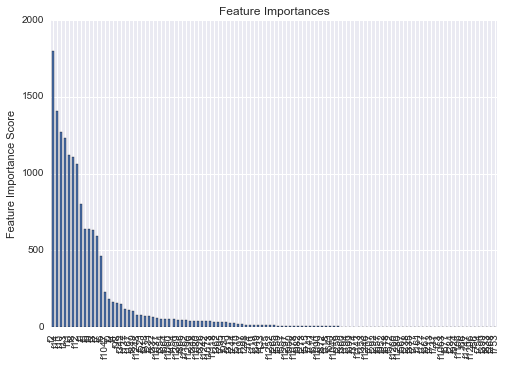

In [66]:
feat_imp = pd.Series(XGB_model.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [79]:
train[simple_features].columns[2], train[simple_features].columns[14], train[simple_features].columns[10]

(u'price', 'NTACode', u'manager_id')

In [88]:
len(simple_features)

15

In [81]:
train[simple_features].head(1)

,bathrooms,bedrooms,price,day_created,month_created,hour_created,weekday_created,number_of_features,desc_length,num_photos,manager_id,building_id,street_address,display_address,NTACode
0,1.5,3,3000,24,6,7,4,0,588,5,1567,3797,23482,12281,45


In [87]:
for v in X_train.toarray()[0][:20]:
    print v

1.5
3.0
3000.0
24.0
6.0
7.0
4.0
0.0
588.0
5.0
1567.0
3797.0
23482.0
12281.0
45.0
1.0
0.0
0.0
0.0
0.0


In [89]:
X_train.toarray()[0][1047]

0.0

In [105]:
print unique_feature_list[1047-15]
print unique_feature_list[98-15]
print unique_feature_list[342-15]
print unique_feature_list[137-15]
print unique_feature_list[167-15]
print unique_feature_list[849-15]
print unique_feature_list[1248-15]
print unique_feature_list[521-15]
print unique_feature_list[918-15]
print unique_feature_list[231-15]
print unique_feature_list[337-15]
print unique_feature_list[1037-15]
print unique_feature_list[354-15]

no fee
laundry in building
furnished
hardwood floors
reduced fee
laundry in unit
dogs allowed
elevator
doorman
dishwasher
exclusive
pre-war
fitness center


In [80]:
print [(i,v) for i, v in enumerate(simple_features)]

[(0, 'bathrooms'), (1, 'bedrooms'), (2, 'price'), (3, 'day_created'), (4, 'month_created'), (5, 'hour_created'), (6, 'weekday_created'), (7, 'number_of_features'), (8, 'desc_length'), (9, 'num_photos'), (10, 'manager_id'), (11, 'building_id'), (12, 'street_address'), (13, 'display_address'), (14, 'NTACode')]


In [103]:
feat_imp

f2       1802
f14      1407
f10      1274
f13      1230
f11      1121
f8       1105
f12      1061
f1        804
f5        641
f9        640
f3        634
f7        594
f6        465
f1047     230
f0        181
f4        162
f98       157
f342      150
f137      115
f167      112
f849      106
f1248      78
f521       77
f918       71
f231       70
f337       63
f1037      58
f354       54
f664       54
f1060      51
         ... 
f657        2
f952        2
f618        2
f572        2
f1260       2
f1280       2
f567        2
f238        2
f335        2
f777        2
f161        2
f177        2
f667        2
f713        1
f737        1
f73         1
f1063       1
f677        1
f284        1
f924        1
f1106       1
f66         1
f1147       1
f1296       1
f56         1
f754        1
f399        1
f833        1
f268        1
f753        1
dtype: int64